In [1]:
!ml load cuda/11.8.0-fasrc01

In [7]:
from IPython.display import Image

In [2]:
import torch
from pathlib import Path
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.cameras.rays import RayBundle
import matplotlib.pyplot as plt
import numpy as np


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Model loading

In [3]:
config_path = "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/nerfacto/2024-08-01_153850/config.yml"
_, pipeline, _, _ = eval_setup(config_path=Path(config_path), test_mode="inference")
nerf_model = pipeline.model
device = pipeline.device

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/nerfacto/2024-08-01_153850/nerfstudio_models/step-000029999.ckpt

In [ ]:
def calculate_camera_to_world_matrix(eye: torch.Tensor, target: torch.Tensor, up: torch.Tensor) -> torch.Tensor:
    forward = (eye - target) / torch.norm(target - eye)
    right = torch.cross((up - eye), forward)
    right /= torch.norm(right)
    up = torch.cross(forward, right)
    rotation_matrices = torch.stack([right, up, forward], dim=-1)
    camera_to_world_matrices = torch.eye(4, device=eye.device)
    camera_to_world_matrices[:3, :3] = rotation_matrices
    camera_to_world_matrices[:3, 3] = eye
    return camera_to_world_matrices[:3, :].unsqueeze(0)


def rotation_matrix_y(angles: torch.Tensor) -> torch.Tensor:
    cos_angles = torch.cos(angles)
    sin_angles = torch.sin(angles)
    rotation_matrices = torch.zeros((angles.shape[0], 3, 3), device=angles.device)
    rotation_matrices[:, 0, 0] = cos_angles
    rotation_matrices[:, 0, 2] = sin_angles
    rotation_matrices[:, 1, 1] = 1
    rotation_matrices[:, 2, 0] = -sin_angles
    rotation_matrices[:, 2, 2] = cos_angles
    return rotation_matrices


def rotate_camera_to_world_matrices(camera_to_worlds: torch.Tensor, start_angle: float, end_angle: float,
                                    intermediate_steps: int) -> torch.Tensor:
    device = camera_to_worlds.device
    start_angle = np.deg2rad(start_angle)
    end_angle = np.deg2rad(end_angle)
    angles = torch.linspace(start_angle, end_angle, intermediate_steps, device=device)
    rotation_matrices = rotation_matrix_y(angles).transpose(1, 2)

    num_cameras = camera_to_worlds.shape[0]
    num_rotations = rotation_matrices.shape[0]

    expanded_camera_matrices = camera_to_worlds.unsqueeze(1).repeat(1, num_rotations, 1, 1)
    expanded_rotation_matrices = rotation_matrices.unsqueeze(0).repeat(num_cameras, 1, 1, 1)

    rotated_matrices = torch.matmul(expanded_camera_matrices[..., :3], expanded_rotation_matrices)
    result_matrices = torch.cat((rotated_matrices, expanded_camera_matrices[..., 3:]), dim=-1)

    return result_matrices.view(-1, 3, 4)

In [ ]:
# Step 3: Define camera parameters
camera_params = {
    "camera_angle_x": 0.5235987755982988,
    "camera_angle_y": 0.5235987755982988,
    "fl_x": 955.4050067376327,
    "fl_y": 955.4050067376327,
    "cx": 256.0,
    "cy": 256.0,
    "w": 512,
    "h": 512,
}

In [ ]:
def create_camera(camera_params, transform_matrix, device):
    fx, fy = camera_params['fl_x'], camera_params['fl_y']
    cx, cy = camera_params['cx'], camera_params['cy']
    width, height = camera_params['w'], camera_params['h']

    camera = Cameras(
        fx=torch.tensor([fx], device=device),
        fy=torch.tensor([fy], device=device),
        cx=torch.tensor([cx], device=device),
        cy=torch.tensor([cy], device=device),
        camera_to_worlds=transform_matrix,
        width=torch.tensor([width], device=device),
        height=torch.tensor([height], device=device),
        camera_type=CameraType.PERSPECTIVE
    )
    return camera


def render_image(model, camera):
    with torch.no_grad():
        outputs = model.get_outputs_for_camera(camera)
    return outputs['rgb']


def post_process_and_save(rgb_image, output_path):
    rgb_image = rgb_image.cpu().numpy()
    rgb_image = (rgb_image * 255).astype('uint8')
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()


def generate_rgb_image(camera_params, transform_matrix, device, model, output_path, start_angle, end_angle,
                       intermediate_steps):
    eye = torch.tensor([-80.73672706466026, 15.51473463480075, 12.348141976499424], device=device)
    target = torch.tensor([0.0, 0.0, 0.0], device=device)
    up = torch.tensor([0.0, -1.0, 0.0], device=device)

    camera_to_world = calculate_camera_to_world_matrix(eye, target, up)
    rotated_matrices = rotate_camera_to_world_matrices(camera_to_world, start_angle, end_angle, intermediate_steps)

    camera = create_camera(camera_params, rotated_matrices, device)
    rgb_image = render_image(model, camera)

    post_process_and_save(rgb_image, output_path)

In [ ]:
# Example usage
transform_matrix = torch.tensor([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424],
    [0.0, 0.0, 0.0, 1.0]
], device=device)

output_path = "output_rgb_image.png"
start_angle = 0.0
end_angle = 345.0
intermediate_steps = 20

generate_rgb_image(camera_params, transform_matrix, device, nerf_model, output_path, start_angle, end_angle,
                   intermediate_steps)
print(f"RGB image saved to {output_path}")

### Second implementation

In [4]:
camera_params = {
    "fx": 955.4050067376327,
    "fy": 955.4050067376327,
    "cx": 256.0,
    "cy": 256.0,
    "width": 512,
    "height": 512,
}


def create_camera(camera_params, camera_to_world, device):
    camera = Cameras(
        fx=torch.tensor([camera_params['fx']], device=device),
        fy=torch.tensor([camera_params['fy']], device=device),
        cx=torch.tensor([camera_params['cx']], device=device),
        cy=torch.tensor([camera_params['cy']], device=device),
        camera_to_worlds=camera_to_world,
        width=torch.tensor([camera_params['width']], device=device),
        height=torch.tensor([camera_params['height']], device=device),
        camera_type=CameraType.PERSPECTIVE
    )
    return camera


def render_image(model, camera):
    with torch.no_grad():
        outputs = model.get_outputs_for_camera(camera)
    return outputs['rgb']


def post_process_and_save(rgb_image, output_path):
    rgb_image = rgb_image.cpu().numpy()
    rgb_image = (rgb_image * 255).astype('uint8')
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()


def generate_rgb_image(camera_params, camera_to_world, device, model, output_path):
    camera = create_camera(camera_params, camera_to_world, device)
    rgb_image = render_image(model, camera)
    post_process_and_save(rgb_image, output_path)

In [9]:
camera_to_world = torch.tensor([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424]
], device=device).unsqueeze(0)  # Add batch dimension

output_path = "output_rgb_image.png"

generate_rgb_image(camera_params, camera_to_world, device, nerf_model, output_path)
print(f"RGB image saved to {output_path}")

AssertionError: 

data	main.py		output_rgb_image.png  README.md
losses	nerf_inversion	outputs		      testing.ipynb


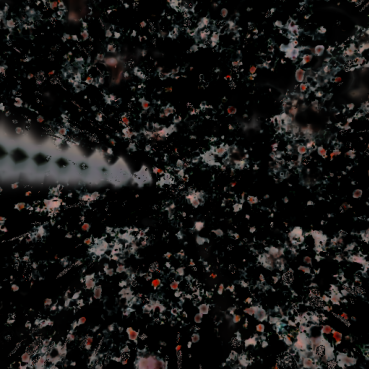

In [8]:
image_path = 'output_rgb_image.png'
Image(filename=image_path)

### Creating RayBundles

In [17]:
def create_ray_bundle(origins, directions, pixel_area=None, nears=None, fars=None):
    # Ensure inputs are PyTorch tensors
    origins = torch.tensor(origins, dtype=torch.float32)
    directions = torch.tensor(directions, dtype=torch.float32)

    # Normalize directions
    directions = directions / torch.norm(directions, dim=-1, keepdim=True)

    # If not provided, set default values
    if pixel_area is None:
        pixel_area = torch.ones_like(origins[..., :1])
    if nears is None:
        nears = torch.zeros_like(origins[..., :1])
    if fars is None:
        fars = torch.ones_like(origins[..., :1]) * 1000  # A large default value

    return RayBundle(
        origins=origins,
        directions=directions,
        pixel_area=pixel_area,
        nears=nears,
        fars=fars
    )


def create_ray_bundle_for_texture(width=512, height=512, focal_length=500, camera_position=(0, 0, -1)):
    """
    Create a RayBundle for a 512x512x3 RGB texture window.
    
    Args:
    - width, height: dimensions of the texture (default: 512x512)
    - focal_length: focal length of the virtual camera (adjust as needed)
    - camera_position: position of the camera (default: looking along +z axis)
    
    Returns:
    - RayBundle representing the rays for each pixel in the texture
    """

    # Create pixel coordinates
    i, j = torch.meshgrid(torch.arange(width), torch.arange(height), indexing='ij')
    i, j = i.transpose(-1, -2), j.transpose(-1, -2)

    # Convert pixel coordinates to normalized device coordinates
    x = (i - width / 2) / focal_length
    y = (j - height / 2) / focal_length

    # Create direction vectors
    directions = torch.stack([x, -y, torch.ones_like(x)], dim=-1)

    # Normalize directions
    directions = directions / torch.norm(directions, dim=-1, keepdim=True)

    # Create origins (same for all pixels in this case)
    origins = torch.tensor(camera_position).expand(height, width, 3)

    # Pixel area (approximation, you might want to adjust this)
    pixel_area = torch.ones_like(directions[..., :1]) * (1 / focal_length) ** 2

    # Near and far planes
    nears = torch.zeros_like(directions[..., :1])
    fars = torch.ones_like(directions[..., :1]) * 1000  # Adjust as needed

    return RayBundle(
        origins=origins,
        directions=directions,
        pixel_area=pixel_area,
        nears=nears,
        fars=fars
    )


In [18]:
# Example usage:
origins = [[0, 0, 0], [1, 1, 1]]  # Two ray origins
directions = [[0, 0, 1], [1, 0, 0]]  # Corresponding directions
ray_bundle = create_ray_bundle(origins, directions)

In [19]:
ray_bundle

RayBundle(origins=tensor([[0., 0., 0.],
        [1., 1., 1.]]), directions=tensor([[0., 0., 1.],
        [1., 0., 0.]]), pixel_area=tensor([[1.],
        [1.]]), camera_indices=None, nears=tensor([[0.],
        [0.]]), fars=tensor([[1000.],
        [1000.]]), metadata={}, times=None)

In [11]:
ray_bundle = create_ray_bundle_for_texture()

In [16]:
ray_bundle

RayBundle(origins=tensor([[[ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1],
         ...,
         [ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1]],

        [[ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1],
         ...,
         [ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1]],

        [[ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1],
         ...,
         [ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1]],

        ...,

        [[ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1],
         ...,
         [ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1]],

        [[ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1],
         ...,
         [ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1]],

        [[ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1],
         ...,
         [ 0,  0, -1],
         [ 0,  0, -1],
         [ 0,  0, -1]]]), directions=tensor([[[-0.4147,  0.4147,  0.8

In [20]:
nerf_model.get_outputs(ray_bundle)

AttributeError: Camera indices are not provided.